# Ulcerative Colitis: data analysis for XAUT1-Blood

## Load the datasets

In [12]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib.pyplot import rc_context
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
import scvi
import sys
import tqdm
import utils

In [13]:
#print package versions
print('package versions:')
print('\n'.join(f'{m.__name__} {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

# # make sure you use these two parameters before saving figures to pdf
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(dpi=600, color_map = 'viridis_r')
sc.logging.print_header()

package versions:
numpy 1.20.3
pandas 1.4.4
seaborn 0.11.2
scanpy 1.9.1
scvi 0.19.0
matplotlib 3.4.3
anndata 0.8.0
scanpy 1.9.1
h5py 3.2.1
tifffile 2021.7.2
fs 2.4.16
tqdm 4.62.3
scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.3 scipy==1.7.1 pandas==1.4.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.10 pynndescent==0.5.6


In [14]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import numpy as np
from scipy.sparse import csr_matrix
from scipy.stats import ks_2samp
import anndata
import scanpy
import string
import seaborn as sns
import h5py
import tifffile
import fs
from fs import open_fs
from matplotlib_scalebar.scalebar import ScaleBar
from tqdm import tqdm

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

In [5]:
# Read the adata object
adata = sc.read_h5ad('blood_RNA.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 20130 × 22741
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent.mt', 'percent.ribo', 'S.Score', 'G2M.Score', 'Phase', 'SAMPLE.by.SNPs', 'nCount_SCT', 'nFeature_SCT', 'DF.DROPLET.TYPE', 'LIBRARY', 'CoLabs_ID', 'CoLabs_patient', 'condition', 'MK final coarse_V2', 'MK final fine annotations_V2', 'MK final coarse_V2 a4B7', 'MK final fine annotations_V2 a4B7'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'dendrogram_MK final coarse_V2', 'neighbors', 'rank_genes_groups'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'
    layers: 'counts'
    obsp: 'distances'

# dot plots for blood scRNA-seq

In [7]:
# check if the adata.X is log-normalized
np.sum(np.expm1(adata.X.todense()),1)

matrix([[10000.],
        [10000.],
        [10000.],
        ...,
        [10000.],
        [10000.],
        [10000.]])

In [8]:
# First, let's subset the anndata for fine cell-type groups
adata_B = adata[adata.obs["MK final fine annotations_V2"].isin(
    ['01A_B_naive','01B_B_memory'])]
adata_CD4 = adata[adata.obs["MK final fine annotations_V2"].isin(
    ['03B_CD4 TEM and CTL',
     '03C_CD4_NAIVE', 
     '03D_dnT'])]
adata_CD8 = adata[adata.obs["MK final fine annotations_V2"].isin(
    ['06A_CD8 TEM',
 '06B_CD8 TCM',
 '06C_CD8_NAIVE'])]

In [9]:
# Run Wilcoxon rank sum test for all these subsetted anndata (as well as the full anndata)
sc.tl.rank_genes_groups(adata, groupby='MK final coarse_V2', method='wilcoxon')
sc.tl.rank_genes_groups(adata_B, groupby='MK final fine annotations_V2', method='wilcoxon')
sc.tl.rank_genes_groups(adata_CD4, groupby='MK final fine annotations_V2', method='wilcoxon')
sc.tl.rank_genes_groups(adata_CD8, groupby='MK final fine annotations_V2', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:42)
ranking genes


/opt/anaconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/opt/anaconda3/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
ranking genes


/opt/anaconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/opt/anaconda3/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes


/opt/anaconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/opt/anaconda3/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


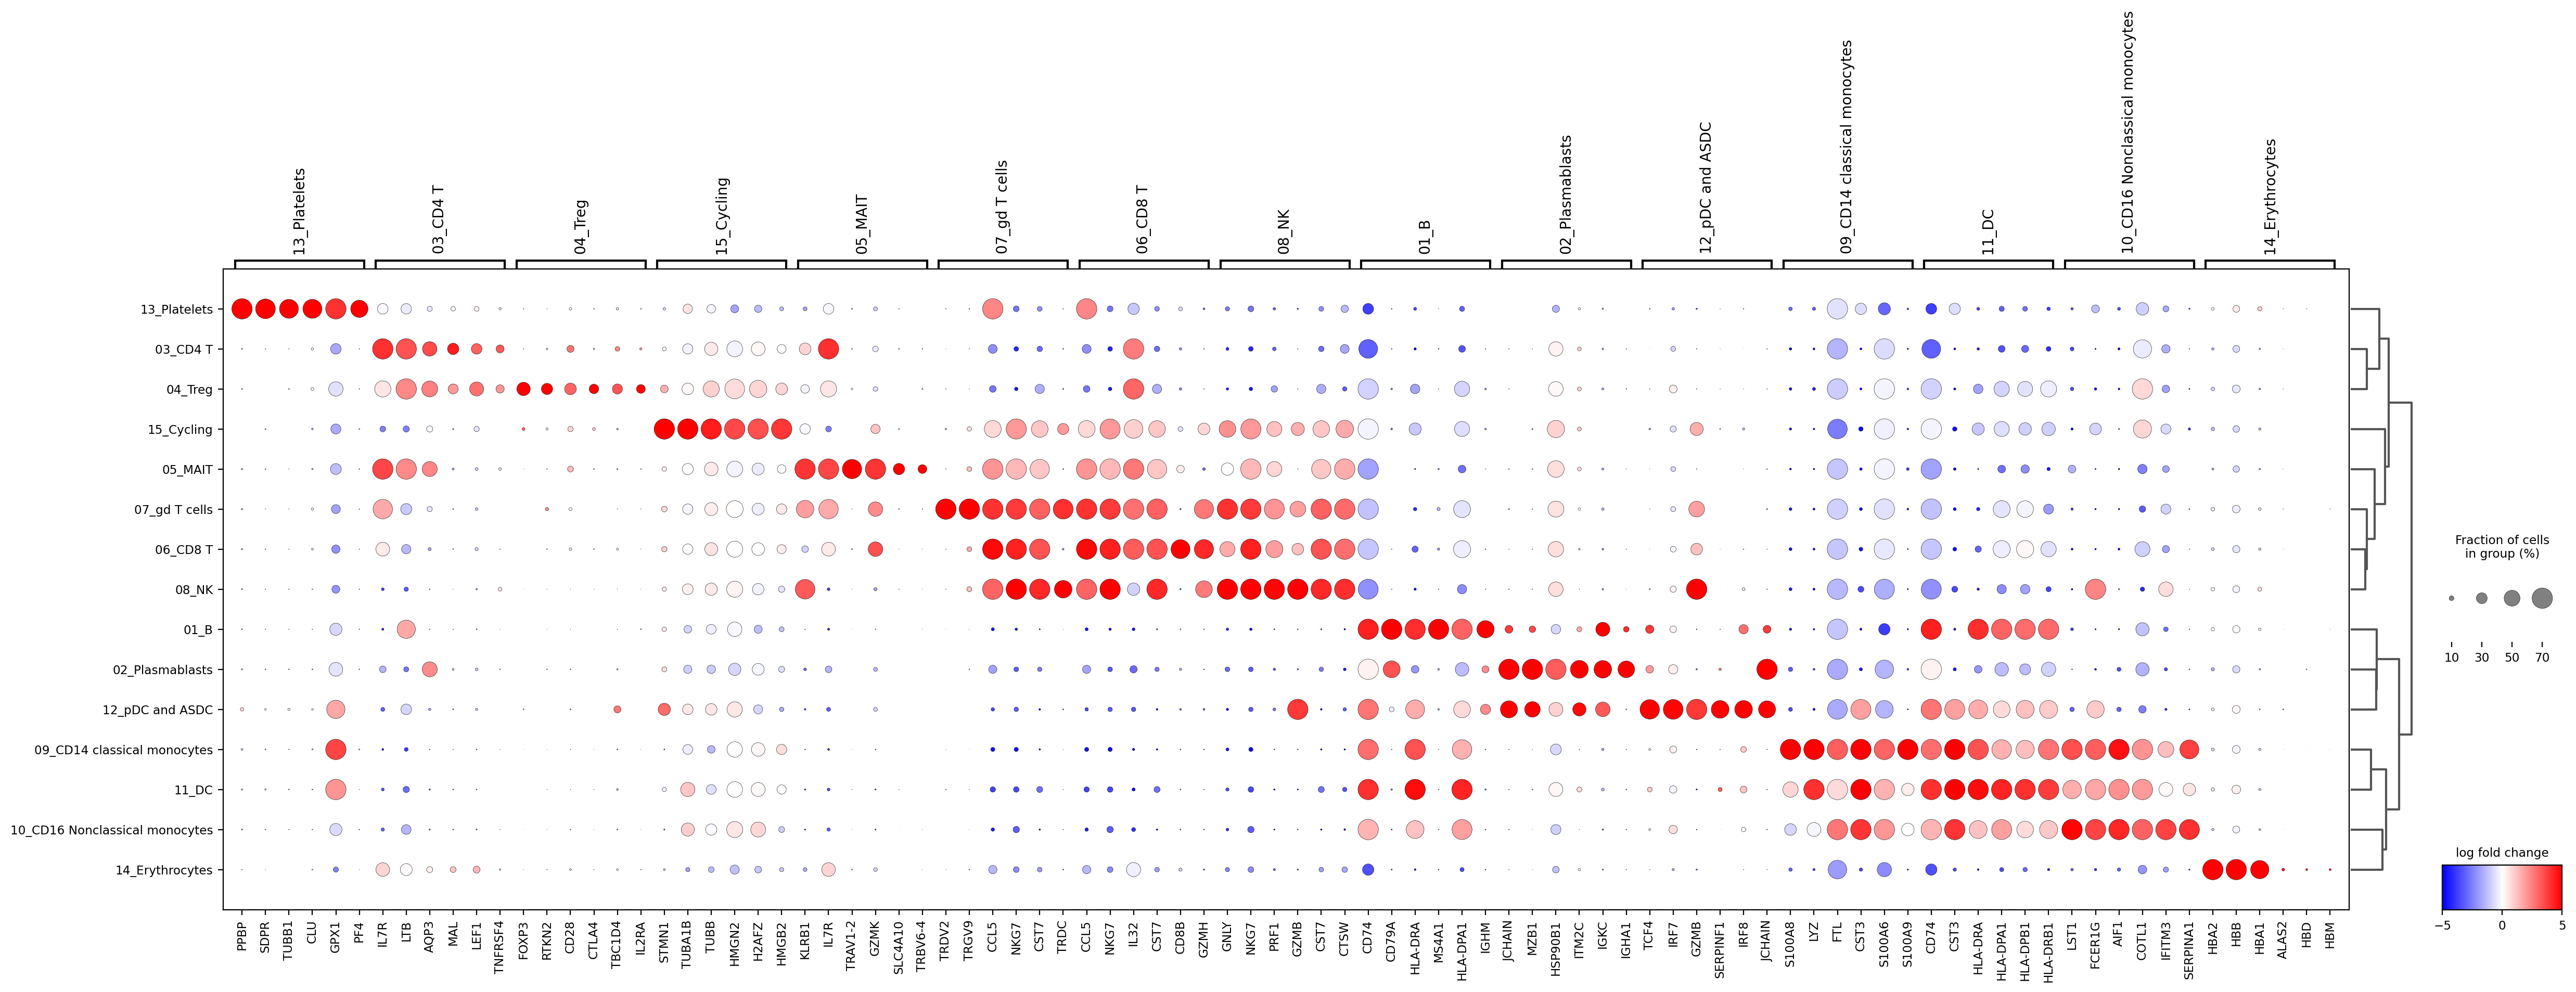

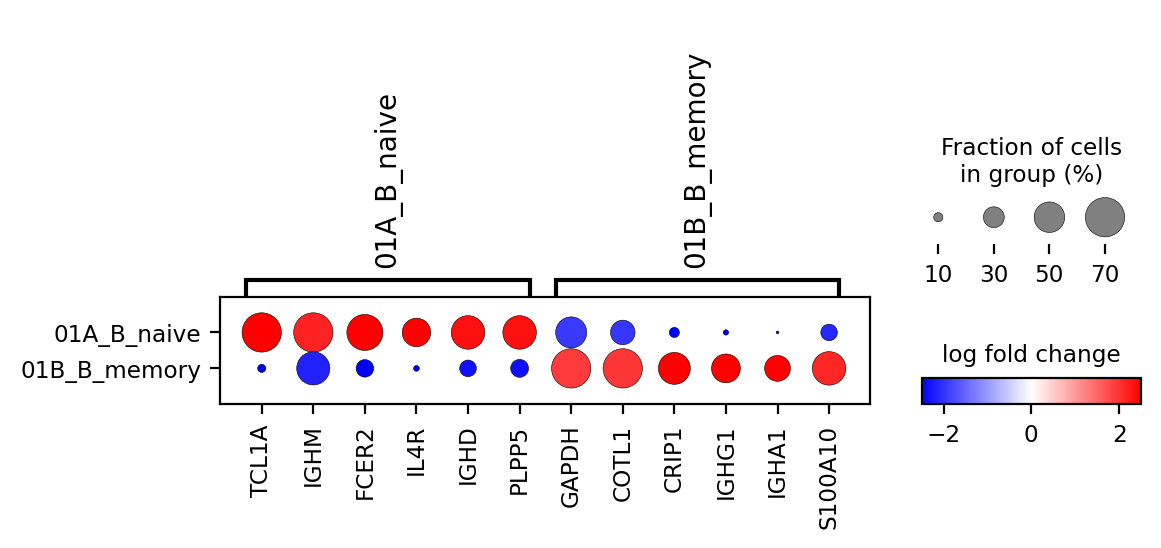

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_MK final fine annotations_V2']`


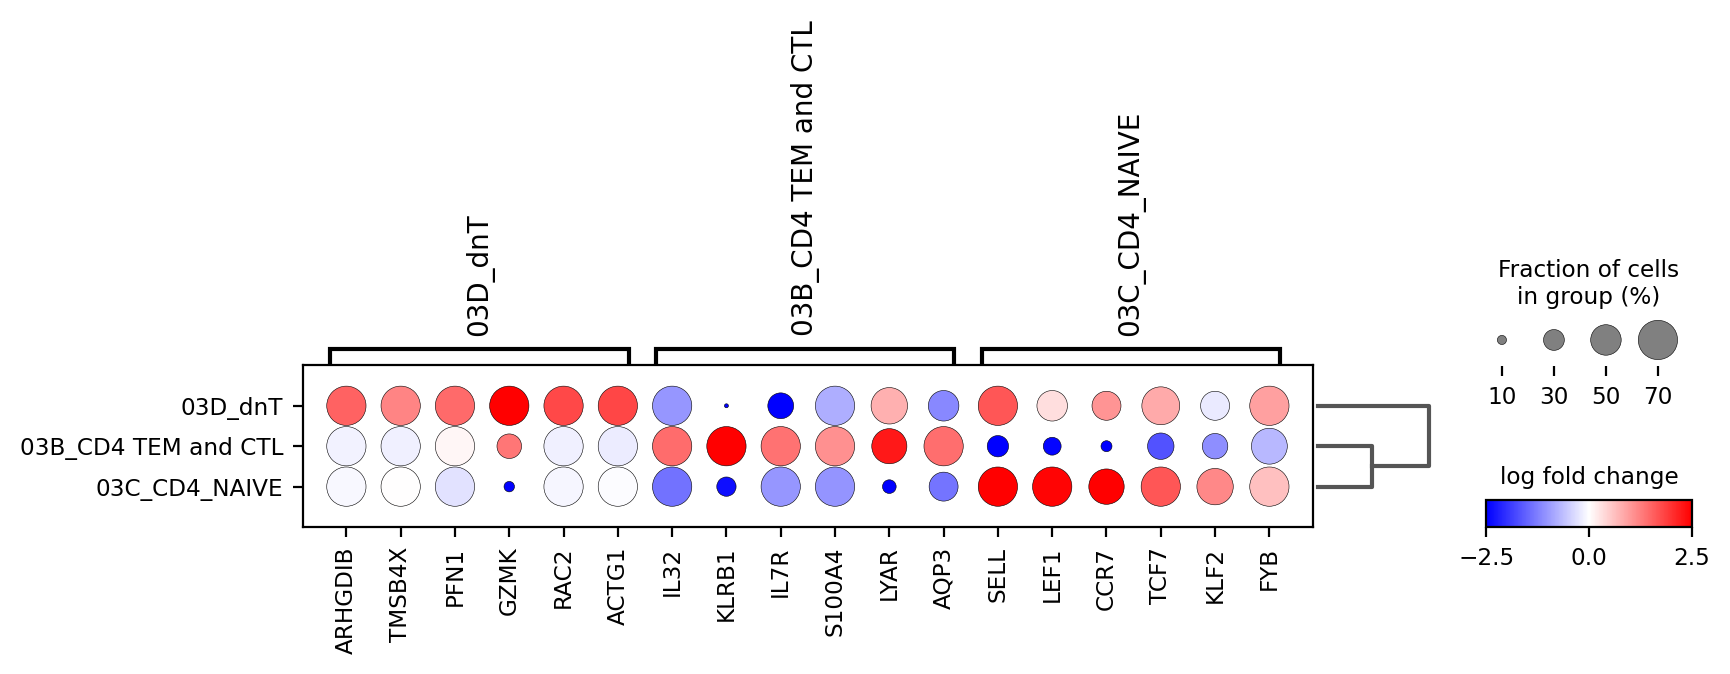

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_MK final fine annotations_V2']`


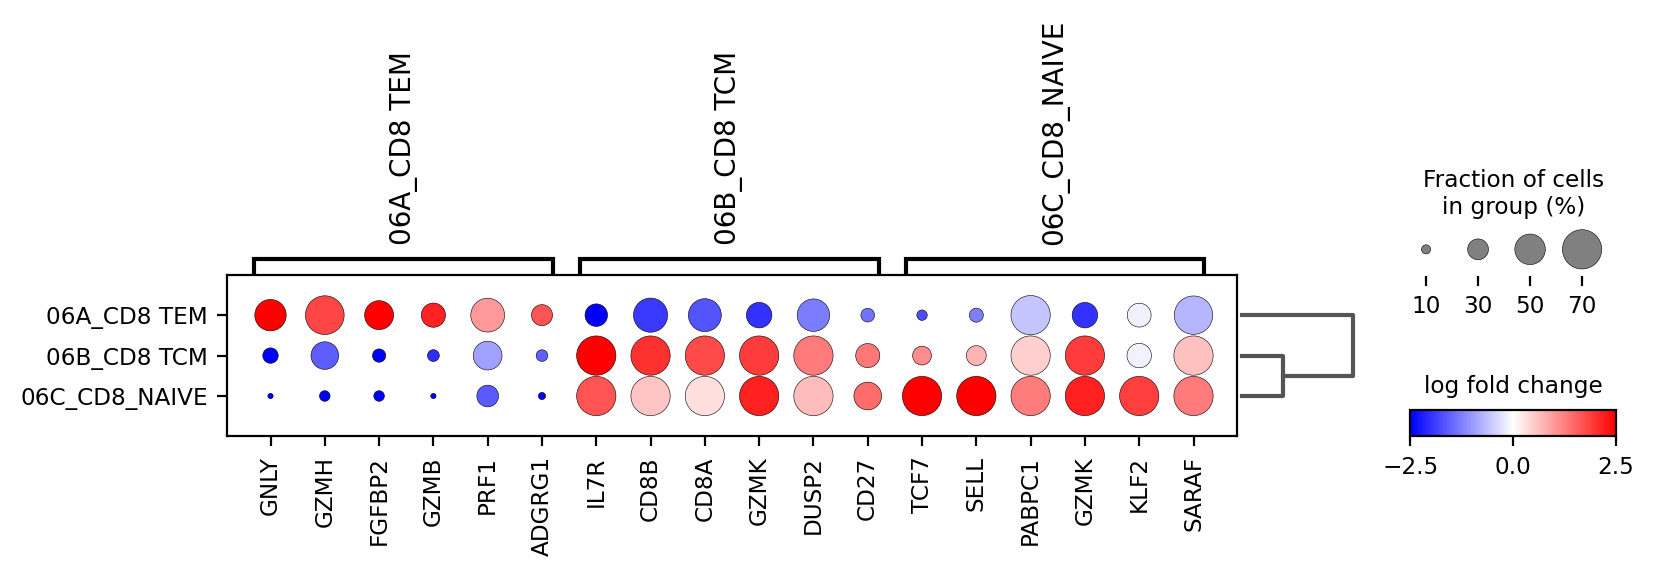

In [10]:
# Generating the dot plots for top 6 genes from Wilcoxon rank sum test
sc.pl.rank_genes_groups_dotplot(adata, n_genes=6, values_to_plot='logfoldchanges', min_logfoldchange=3, vmax=5, vmin=-5, cmap='bwr', figsize=(29,8), dot_max=0.7, save="23_1_28_blood_all_coarse.pdf")
sc.pl.rank_genes_groups_dotplot(adata_B, n_genes=6, values_to_plot='logfoldchanges', min_logfoldchange=1.75, vmax=2.5, vmin=-2.5,dot_max=0.7, cmap='bwr', save="23_1_28_blood_B_fine.pdf")
sc.pl.rank_genes_groups_dotplot(adata_CD4, n_genes=6, values_to_plot='logfoldchanges', min_logfoldchange=0.5, vmax=2.5, vmin=-2.5,dot_max=0.7, cmap='bwr', save="23_1_28_blood_CD4_fine.pdf")
sc.pl.rank_genes_groups_dotplot(adata_CD8, n_genes=6, values_to_plot='logfoldchanges', min_logfoldchange=1, vmax=2.5, vmin=-2.5,dot_max=0.7, cmap='bwr', save="23_1_28_blood_CD8_fine.pdf")

## UMAP visualization

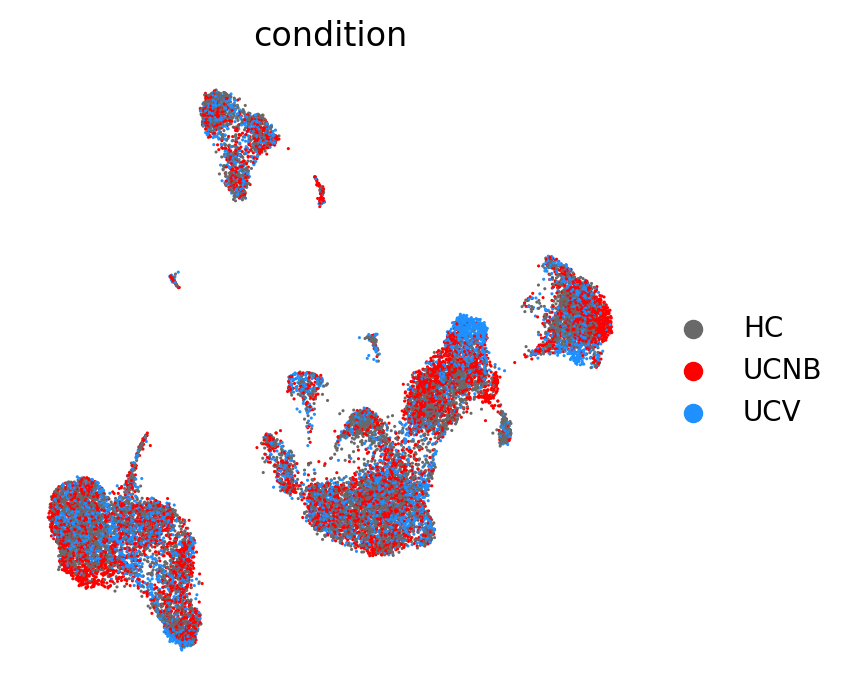

In [33]:
# Subsetting to a smaller number of categories:
adata = adata[adata.obs["condition"].isin(["HC", "UCNB", "UCV"])].copy()
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(
    adata,
    color="condition",
    s=5, 
    frameon=False, 
    ncols=4,
    vmax='p99',
    palette={
        "HC": "dimgrey",
        "UCNB": "red",
        "UCV": "dodgerblue",},
        show=False)
    plt.savefig("23_1_28_umap_blood_condition.pdf", bbox_inches="tight", dpi=600)
    plt.show()

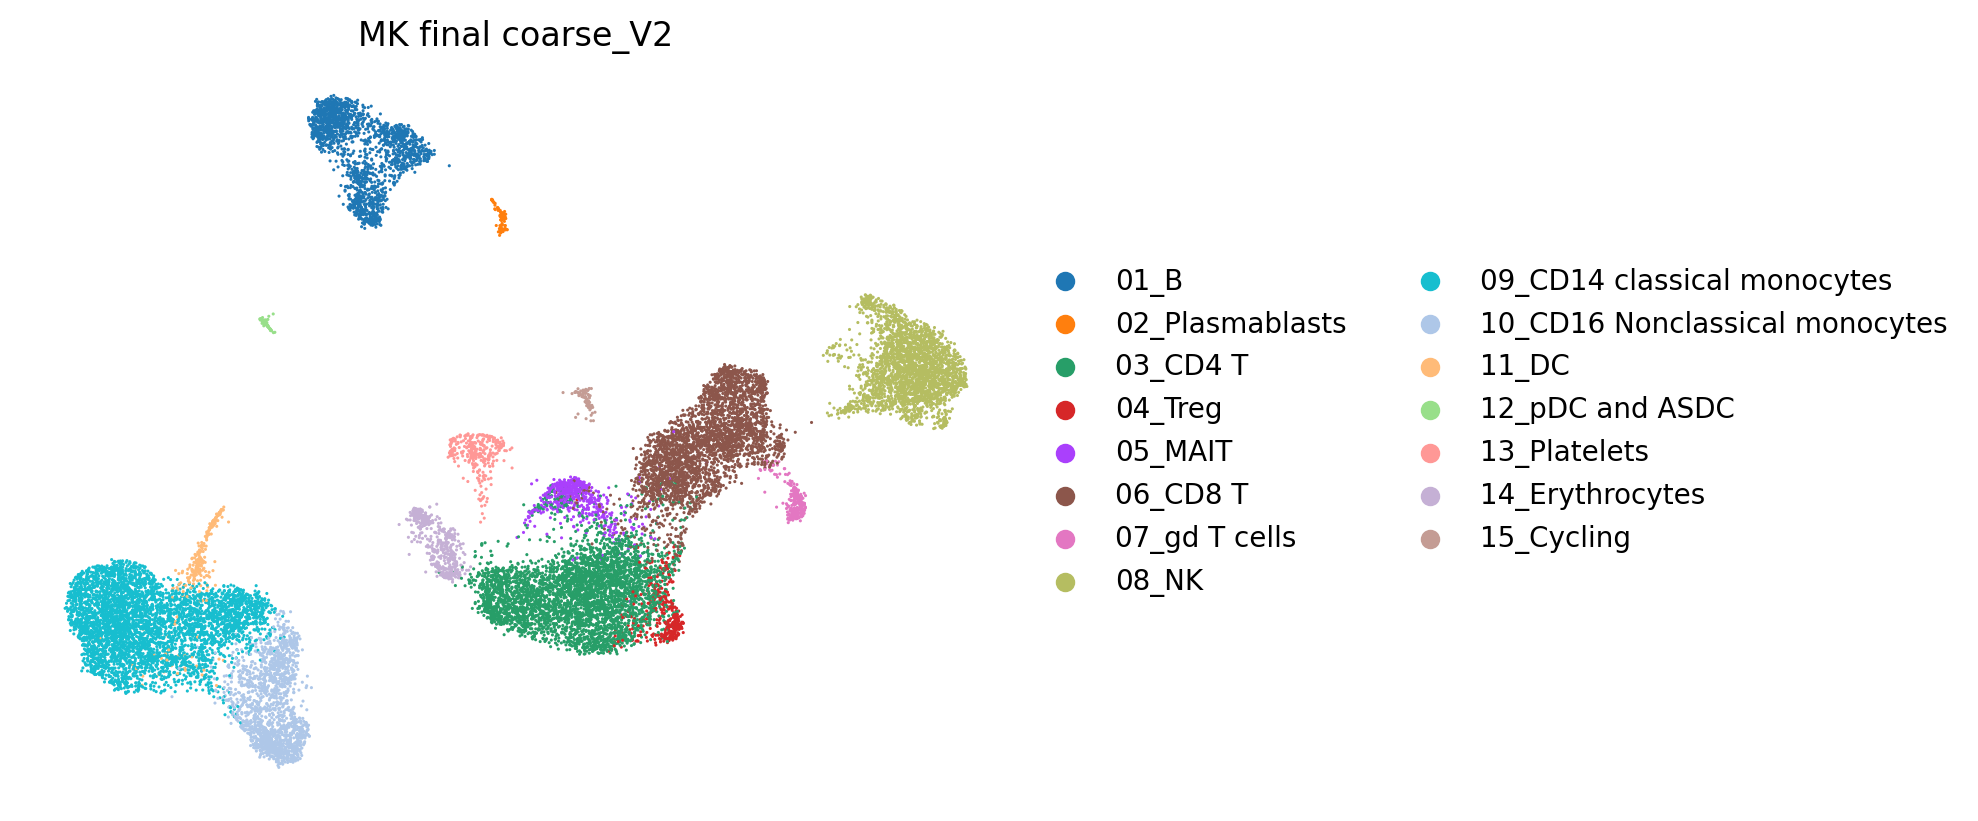

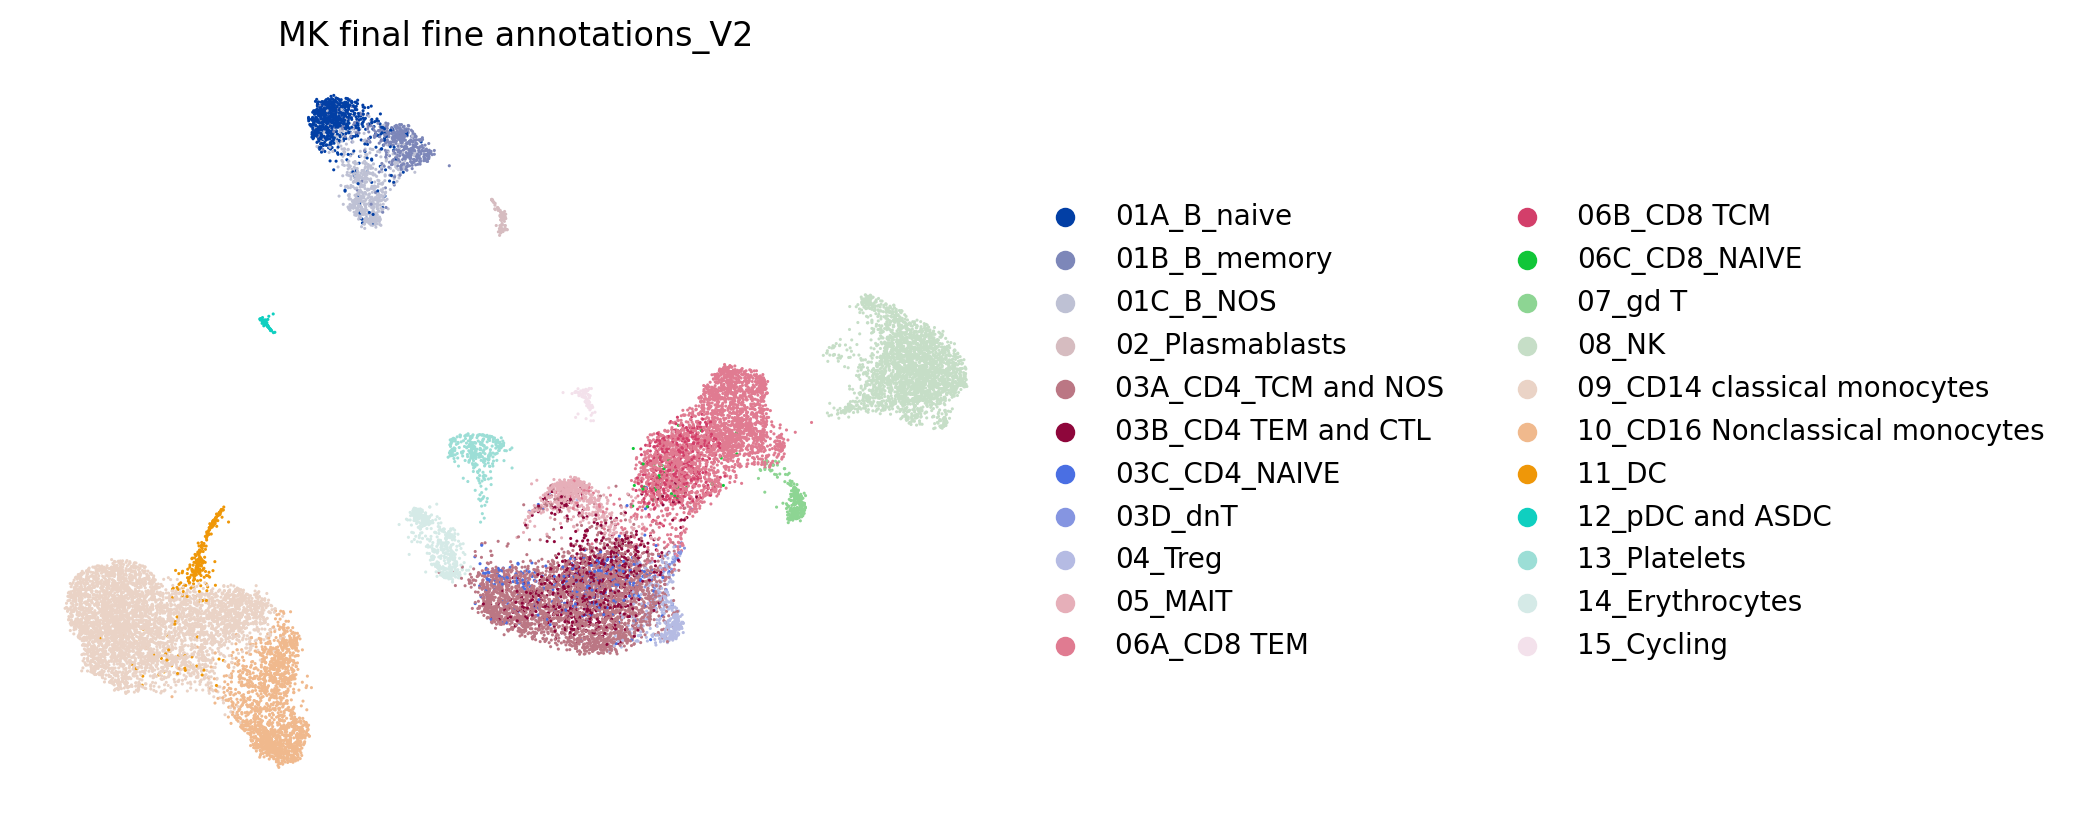

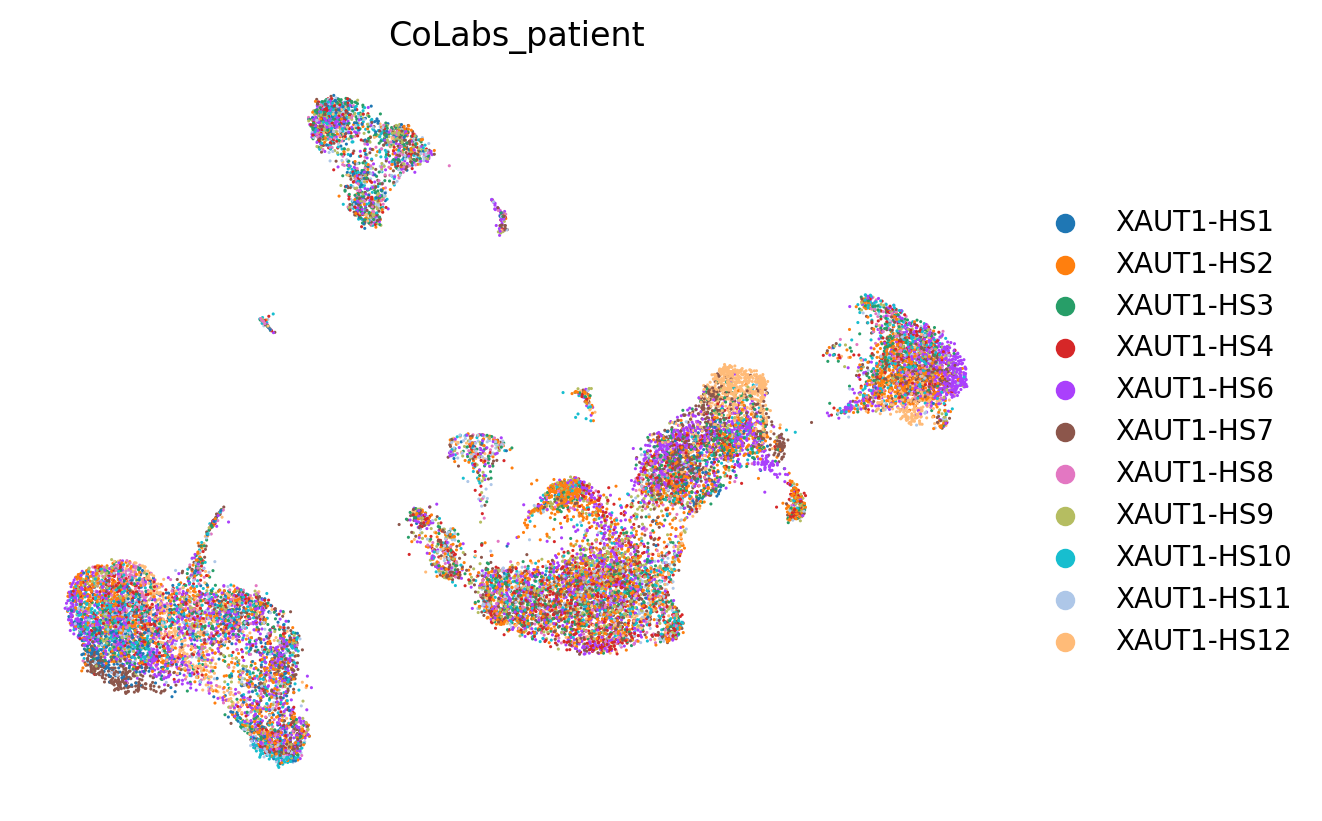

In [35]:
# different UMAP visualizations (different groups)
sc.pl.umap(adata, color=['MK final coarse_V2'],s=5, frameon=False, ncols=4, vmax='p99', show=False)
plt.savefig("23_1_28_blood_coarse.pdf", bbox_inches="tight", dpi=600)
plt.show()

sc.pl.umap(adata, color=['MK final fine annotations_V2'],s=5, frameon=False, ncols=4, vmax='p99', show=False)
plt.savefig("23_1_28_blood_fine.pdf", bbox_inches="tight", dpi=600)
plt.show()

sc.pl.umap(adata, color=['CoLabs_patient'],s=5, frameon=False, ncols=4, vmax='p99', show=False)
plt.savefig("23_1_28_blood_patient.pdf", bbox_inches="tight", dpi=600)
plt.show()

## Cell type abundances table

In [27]:
list_cell_types = adata.obs["MK final fine annotations_V2"].unique().to_list()
list_cell_types.sort()
list_cell_types

['01A_B_naive',
 '01B_B_memory',
 '01C_B_NOS',
 '02_Plasmablasts',
 '03A_CD4_TCM and NOS',
 '03B_CD4 TEM and CTL',
 '03C_CD4_NAIVE',
 '03D_dnT',
 '04_Treg',
 '05_MAIT',
 '06A_CD8 TEM',
 '06B_CD8 TCM',
 '06C_CD8_NAIVE',
 '07_gd T',
 '08_NK',
 '09_CD14 classical monocytes',
 '10_CD16 Nonclassical monocytes',
 '11_DC',
 '12_pDC and ASDC',
 '13_Platelets',
 '14_Erythrocytes',
 '15_Cycling']

In [28]:
list_patient_IDs = adata.obs["CoLabs_patient"].unique().to_list()
list_patient_IDs.sort()
list_patient_IDs

['XAUT1-HS1',
 'XAUT1-HS10',
 'XAUT1-HS11',
 'XAUT1-HS12',
 'XAUT1-HS2',
 'XAUT1-HS3',
 'XAUT1-HS4',
 'XAUT1-HS6',
 'XAUT1-HS7',
 'XAUT1-HS8',
 'XAUT1-HS9']

In [29]:
# initialize the dataframe
cell_type_abundances = pd.DataFrame(np.zeros((len(list_patient_IDs), len(list_cell_types))),dtype = np.int16,
                                    index = list_patient_IDs,
                                    columns = list_cell_types)

cell_type_abundances

,01A_B_naive,01B_B_memory,01C_B_NOS,02_Plasmablasts,03A_CD4_TCM and NOS,03B_CD4 TEM and CTL,03C_CD4_NAIVE,03D_dnT,04_Treg,05_MAIT,...,06C_CD8_NAIVE,07_gd T,08_NK,09_CD14 classical monocytes,10_CD16 Nonclassical monocytes,11_DC,12_pDC and ASDC,13_Platelets,14_Erythrocytes,15_Cycling
XAUT1-HS1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
XAUT1-HS10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
XAUT1-HS11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
XAUT1-HS12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
XAUT1-HS2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
XAUT1-HS3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
XAUT1-HS4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
XAUT1-HS6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
XAUT1-HS7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
XAUT1-HS8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# calculate the number of cells in each cell-type for each patient, then fill in the dataframe
for i in range(0,len(list_patient_IDs)):
    for j in range(0,len(list_cell_types)):
        patient_ID = list_patient_IDs[i]
        cell_type = list_cell_types[j]
        
        num_cells = len(adata[(adata.obs["CoLabs_patient"]==patient_ID) & (adata.obs["MK final fine annotations_V2"]==cell_type)])
        
        cell_type_abundances.loc[patient_ID,cell_type] = num_cells
        
cell_type_abundances

,01A_B_naive,01B_B_memory,01C_B_NOS,02_Plasmablasts,03A_CD4_TCM and NOS,03B_CD4 TEM and CTL,03C_CD4_NAIVE,03D_dnT,04_Treg,05_MAIT,...,06C_CD8_NAIVE,07_gd T,08_NK,09_CD14 classical monocytes,10_CD16 Nonclassical monocytes,11_DC,12_pDC and ASDC,13_Platelets,14_Erythrocytes,15_Cycling
XAUT1-HS1,68,31,55,2,34,4,4,0,3,1,...,1,4,9,433,118,15,4,8,11,0
XAUT1-HS10,118,38,63,2,221,30,24,1,46,27,...,1,6,245,452,203,25,11,17,18,13
XAUT1-HS11,46,41,55,8,159,57,26,3,32,6,...,2,12,74,174,85,30,15,68,46,3
XAUT1-HS12,16,5,15,1,120,23,16,3,25,5,...,0,1,215,347,65,13,5,24,21,7
XAUT1-HS2,24,43,47,7,481,199,60,4,48,240,...,6,90,493,576,255,44,3,43,73,22
XAUT1-HS3,99,75,76,5,251,85,27,2,29,33,...,8,21,182,281,98,34,6,25,44,4
XAUT1-HS4,83,21,47,5,409,61,44,4,48,53,...,2,51,172,378,64,24,5,23,49,5
XAUT1-HS6,88,37,61,36,478,96,44,6,35,95,...,9,33,648,781,292,39,6,35,56,10
XAUT1-HS7,60,58,68,16,376,80,40,2,45,13,...,4,9,312,357,231,30,7,32,80,7
XAUT1-HS8,54,37,54,7,151,35,23,1,18,13,...,5,1,143,334,91,25,11,13,21,0


In [32]:
cell_type_abundances.to_csv('XAUT1_Blood_abundances_V1.csv')